# MechIR Activation Patching

This notebook serves to walk you through a simple example of activation patching in `MechIR`. For more details on the specifics of this process check out our other notebook!.

NOTE: Our initial implementation is flexible enough to support loading a wide variety of Transformer-based IR models, but we have mainly tested the following models:
- TAS-B (bi-encoder) [[Hofstätter et al.]](https://arxiv.org/abs/2104.06967) [[HF model card]](https://huggingface.co/sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco)
- monoELECTRA (cross-encoder) [[Pradeep et al.]](https://link.springer.com/chapter/10.1007/978-3-030-99736-6_44) [[HF model card]](https://huggingface.co/crystina-z/monoELECTRA_LCE_nneg31)

## Setup

In [ ]:
%pip install git+https://github.com/Parry-Parry/MechIR.git
%pip install transformer_lens
%pip install matplotlib seaborn plotly

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Processing /Users/cchen207/git/brown/research/MechIR
  Preparing metadata (setup.py) ... done
  Created wheel for mechir: filename=mechir-0.0.1-py3-none-any.whl size=66580 sha256=4241b7eb8845a4555551762d163cda108fb4b63b267c325fdd617e1d76d6602b
  Stored in directory: /private/var/folders/w8/j9c1qwbx3cn8hf10x5nz_xtr0000gp/T/pip-ephem-wheel-cache-ugqeu0x0/wheels/39/37/7c/9f04c1e8f880bc1e666f79cde17d9e585bcff18fdf2b5a9b0d
Successfully built mechir
  Attempting uninstall: mechir
    Found existing installation: mechir 0.0.1
    Uninstalling mechir-0.0.1:
      Successfully uninstalled mechir-0.0.1
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from mechir import Dot, MechIRDataset, DotDataCollator, Cat, CatDataCollator
from mechir.perturb import perturbation
from mechir.plotting import plot_components

import torch
from torch.utils.data import DataLoader

/opt/anaconda3/envs/mechir/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Model

* `Dot` : A bi-encoder architecture with flexibility for different BERT architectures and pooling forms.
* `Cat` : A cross-encoder architecture with with flexibility for different BERT architectures. Checkout our `monoT5` class if you want to work with sequence-to-sequence models!

In [ ]:
model_name = "sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco"
model = Dot(model_name)

If using BERT for interpretability research, keep in mind that BERT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco into HookedEncoder


In [ ]:
cat_model_name = "crystina-z/monoELECTRA_LCE_nneg31"
cat_model = Cat(cat_model_name)

## Load Dataset

We recommend the use of `ir-datasets` as it is the easiest way to get started with MechIR. By default `MechIR` will load relevance judgements from these datasets however you can change this or even use your own documents and queries using the `MechDataset` class.

In [ ]:
# Load smallest dataset for quick testing
dataset = MechIRDataset("vaswani")
dataset.pairs.head()

,query_id,doc_id,relevance,iteration
0,1,1239,1,0
1,1,1502,1,0
2,1,4462,1,0
3,1,4569,1,0
4,1,5472,1,0


In [ ]:
# Print examples of queries
print("Total queries in dataset:", len(dataset.queries.items()))
print("\n----------- Examples of queries: -----------\n")
example_queries = list(dataset.queries.values())[:3]
for query in example_queries:
    print(query)

Total queries in dataset: 93

----------- Examples of queries: -----------

MEASUREMENT OF DIELECTRIC CONSTANT OF LIQUIDS BY THE USE OF MICROWAVE TECHNIQUES

MATHEMATICAL ANALYSIS AND DESIGN DETAILS OF WAVEGUIDE FED MICROWAVE RADIATIONS

USE OF DIGITAL COMPUTERS IN THE DESIGN OF BAND PASS FILTERS HAVING GIVEN PHASE AND ATTENUATION CHARACTERISTICS



In [ ]:
# Calculate document stats
doc_lengths = [len(doc.split()) for doc in dataset.docs.values()]

# Print examples of documents
print("Total documents in dataset:", len(dataset.docs.items()))
print(f"Minimum Length (in words): {min(doc_lengths)}")
print(f"Maximum Length (in words): {max(doc_lengths)}")
print(f"Average Length (in words): {(sum(doc_lengths) / len(doc_lengths) if doc_lengths else 0):.2f}")
print("\n----------- Examples of documents: -----------\n")
example_docs = list(dataset.docs.values())[:3]
for doc in example_docs:
    print(doc)

Total documents in dataset: 11429
Minimum Length (in words): 2
Maximum Length (in words): 269
Average Length (in words): 41.93

----------- Examples of documents: -----------

compact memories have flexible capacities  a digital data storage
system with capacity up to bits and random and or sequential access
is described

an electronic analogue computer for solving systems of linear equations
mathematical derivation of the operating principle and stability
conditions for a computer consisting of amplifiers

electronic coordinate transformer  circuit details are given for
the construction of an electronic calculating unit which enables
the polar coordinates of a vector modulus and cosine or sine of the
argument to be derived from those of a rectangular system of axes



In [ ]:
# Print example of one query and relevant documents
query_rel_doc_ex_df = dataset.pairs.head(3)[["query_id", "doc_id"]]
query_id = query_rel_doc_ex_df["query_id"].unique()[0]
doc_ids = query_rel_doc_ex_df["doc_id"]
print(f"Query: {dataset.queries[query_id]}")
print("-------------------------------")
for doc_id in doc_ids:
    print(f"Document:\n{dataset.docs[doc_id]}")

Query: MEASUREMENT OF DIELECTRIC CONSTANT OF LIQUIDS BY THE USE OF MICROWAVE TECHNIQUES

-------------------------------
Document:
broadband millimetre wave paramagnetic resonance spectrometer  the
specimen and waveguide which can be cooled by means of a cryostat
are placed between close pole pieces giving high uniform magnetic
fields  design details and some measurements on zero field splittings
are given

Document:
microwave measurements of dielectric absorption in dilute solutions

Document:
dielectric properties of ice at very low frequencies and the influence
of a polarizing field  measurements at frequencies down to are reported
the loss factor passes through a low frequency maximum which is distinguishable
from that associated with the dipole dispersion by its different
temperature dependence  the effect of impurities is to shift the
maximum towards higher frequencies  application of a unidirectional
field does not affect the permittivity of the pure crystals but eliminates
the 

### Paired Dataset Creation

Activation patching relies on pairs of inputs, consisting of one *perturbed* input and one *baseline* input, where the *perturbed* input is constructed by applying some function to modify an *original* input (e.g., inserting a query term to the end of a document) and the *baseline* input is a padded variant of the *original* input to maintain token lengths between the pairs.

In the main demo, we show one possible type of perturbation (appending a query term to the end of a document), but there are several other possible types of functions that could be use to generate the activation patching input pairs depending on what behavior you are trying to investigate. In this section, we discuss possible general perturbation methods, and describe some specific perturbations that we define aligning with IR axioms.

In [ ]:
# Helper function just to print
def pretty_print_triplets(batch, tokenizer):
    """
    Pretty prints triplets of queries, documents, and their corresponding perturbed documents from a batch.

    Args:
        batch (dict): A dictionary containing 'queries', 'documents', and 'perturbed_documents' from a DataLoader.
        tokenizer: The tokenizer used to decode the input IDs.
    """
    # Get the queries, documents, and perturbed documents from the batch
    queries = batch["queries"]
    documents = batch["documents"]
    perturbed_documents = batch["perturbed_documents"]

    # Loop through the batch size
    for i in range(len(documents["input_ids"])):
        # Get the input IDs
        query_ids = queries["input_ids"][i]
        original_ids = documents["input_ids"][i]
        perturbed_ids = perturbed_documents["input_ids"][i]

        # Decode the input IDs to text
        query_decoded = tokenizer.decode(query_ids.tolist(), skip_special_tokens=False)
        original_doc_decoded = tokenizer.decode(original_ids.tolist(), skip_special_tokens=False)
        perturbed_doc_decoded = tokenizer.decode(perturbed_ids.tolist(), skip_special_tokens=False)

        # Pretty print
        print(f"Triplet {i + 1}:")
        print("Query:", query_decoded)
        print("Original Document:", original_doc_decoded)
        print("Perturbed Document:", perturbed_doc_decoded)
        print("=" * 50)  # Separator for clarity

## Perturbations

Perturbations are how we explore model behaviour, We observe how a model's behaviour changes when a document changes in some controlled way and isolate this change to particular components.

We provide several built in perturbations but they are easy to create yourself to investigate any model behaviour. In a minimal case a perturbation should recieve a document and output perturbed text but our `@perturbation` decorator can dynamically accept a query so you can execute query-conditioned perturbations.

In [ ]:
# Define perturbation (for now just test simple append static term, later test TF/IDF)

@perturbation
def append(text):
    return text + " microwave techniques"

@perturbation
def prepend(text):
    return "microwave techniques " + text

@perturbation
def prepend_query(text, query=""):
    return query + " " + text

@perturbation
def append_query(text, query=""):
    return text + " " + query

@perturbation
def replace(text):
    return text.replace("dilute", "water")

@perturbation
def insert(text, i, insert_text):
    text_list = text.split()
    return " ".join(text_list[:i] + insert_text + text_list[i:])

# Using Perturbations

Once you have a perturbation and a dataset, we provide collate functions which automatically apply your perturbation to your dataset and allow batching for more efficient experiments. A standard torch dataloader is all you need but remember that different architectures need different input formats so make sure to use the correct collate functon for your model.

In [ ]:
data_collator = DotDataCollator(model.tokenizer, prepend_query)
dataloader = DataLoader(dataset, batch_size=1, collate_fn=data_collator)

In [ ]:
cat_data_collator = CatDataCollator(cat_model.tokenizer, prepend_query)
cat_dataloader = DataLoader(dataset, batch_size=1, collate_fn=cat_data_collator)

In [ ]:
for i, batch in enumerate(dataloader):
    pretty_print_triplets(batch, model.tokenizer)

    # stop after 2 batches
    if i == 1:
        break

Triplet 1:
Query: [CLS] measurement of dielectric constant of liquids by the use of microwave techniques [SEP]
Original Document: [CLS] broadband millimetre wave paramagnetic resonance spectrometer the specimen and waveguide which can be cooled by means of a cryostat are placed between close pole pieces giving high uniform magnetic fields design details and some measurements on zero field splittings are given X X X X X X X X X X X X X X [SEP]
Perturbed Document: [CLS] measurement of dielectric constant of liquids by the use of microwave techniques broadband millimetre wave paramagnetic resonance spectrometer the specimen and waveguide which can be cooled by means of a cryostat are placed between close pole pieces giving high uniform magnetic fields design details and some measurements on zero field splittings are given [SEP]
Triplet 1:
Query: [CLS] measurement of dielectric constant of liquids by the use of microwave techniques [SEP]
Original Document: [CLS] microwave measurements of d

/opt/anaconda3/envs/mechir/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2855: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


### Verify Difference in Performance on Perturbed Pairs

Before we can finalize our paired dataset and proceedto the patching experiments, there's a couple things to check:
- Does the chosen perturbation even have an effect on model behavior?
- If yes, what is that effect? (i.e., Do the *baseline* or *perturbed* inputs have a higher relevance score on average?)

So first, let's calculate the performances of the three toy perturbations we defined earlier (prepend, append, replace) and plot their distributions.

In [ ]:
# Helper function for plotting difference in performance
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_score_dists(baseline_scores, perturbed_scores, type="hist"):
    plt.figure(figsize=(8, 6))

    if type == "hist":
        plt.hist(baseline_scores, label='Baseline', color='blue')
        plt.hist(perturbed_scores, label='Perturbed', color='orange')
        plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('Frequency')
    elif type == "box":
        plt.boxplot([baseline_scores, perturbed_scores], labels=['Baseline', 'Perturbed'])
        plt.ylabel('Scores')

    plt.xlabel('Scores')
    plt.title('Distribution of Baseline vs Perturbed Scores')
    plt.legend()

    plt.show()

    return

In [ ]:
baseline_performance, perturbed_performance = [], []
for i, batch in enumerate(dataloader):
    # Get the queries, documents, and perturbed documents from the batch
    queries = batch["queries"]
    documents = batch["documents"]
    perturbed_documents = batch["perturbed_documents"]

    queries_encoded = model._forward(**queries) # [batch_size x hidden_dim]
    baseline_encoded = model._forward(**documents) # [batch_size x hidden_dim]
    perturbed_encoded = model._forward(**perturbed_documents) # [batch_size x hidden_dim]

    baseline_scores = torch.sum(queries_encoded.unsqueeze(1) * baseline_encoded.unsqueeze(0), dim=2)
    perturbed_scores = torch.sum(queries_encoded.unsqueeze(1) * perturbed_encoded.unsqueeze(0), dim=2)

    baseline_performance += baseline_scores.flatten().tolist()
    perturbed_performance += perturbed_scores.flatten().tolist()

    # stop after 2 batches
    if i == 1:
        break

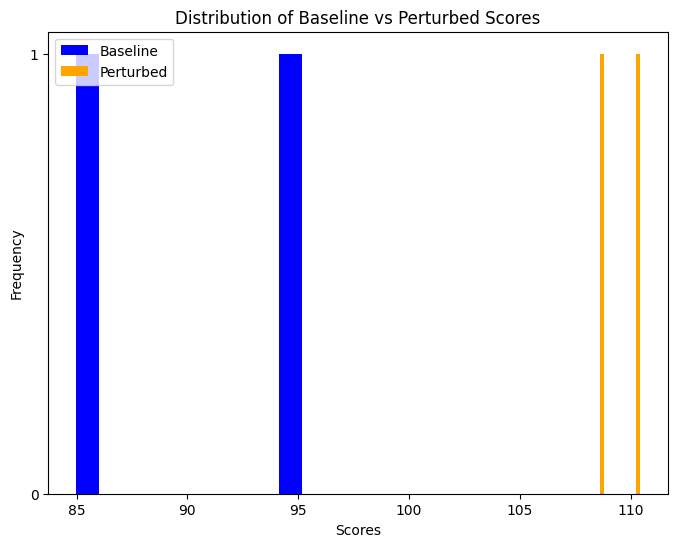

In [ ]:
plot_score_dists(baseline_performance, perturbed_performance)

/var/folders/w8/j9c1qwbx3cn8hf10x5nz_xtr0000gp/T/ipykernel_59318/956876871.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([baseline_scores, perturbed_scores], labels=['Baseline', 'Perturbed'])
/var/folders/w8/j9c1qwbx3cn8hf10x5nz_xtr0000gp/T/ipykernel_59318/956876871.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


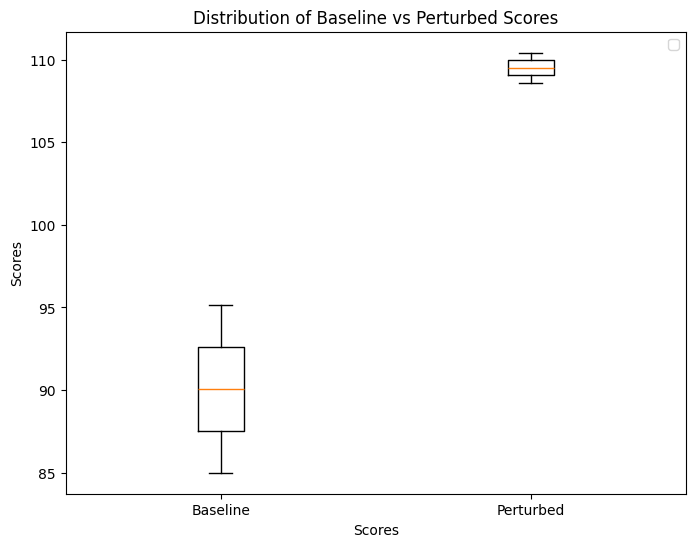

In [ ]:
plot_score_dists(baseline_performance, perturbed_performance, type="box")

In [ ]:
baseline_performance, perturbed_performance = [], []
for i, batch in enumerate(cat_dataloader):
    # Get the queries, documents, and perturbed documents from the batch
    sequences = batch["sequences"]
    perturbed_sequences = batch["perturbed_sequences"]

    baseline_encoded = model._forward(**sequences) # [batch_size x 2]
    perturbed_encoded = model._forward(**perturbed_sequences) # [batch_size x 2]

    baseline_scores = torch.nn.functional.softmax(baseline_encoded, dim=1)[:, 1]
    perturbed_scores = torch.nn.functional.softmax(perturbed_encoded, dim=1)[:, 1]

    baseline_performance += baseline_scores.flatten().tolist()
    perturbed_performance += perturbed_scores.flatten().tolist()

    # stop after 2 batches
    if i == 1:
        break

In [ ]:
plot_score_dists(baseline_performance, perturbed_performance)

In [ ]:
plot_score_dists(baseline_performance, perturbed_performance, type="box")

## Activation Patching

### Setup and Evaluation

Activation patching consists of three forward passes through the model:
1. Baseline run
2. Perturbed run
3. Patched run

Remember in the previous section when we wanted to know the effect of the perturbation on the original input, specifically whether the *perturbed* or *baseline* input had the higher relevance score? Now that information will come into play, determining which "direction" we will perform activation patching, and what information we need to store in runs (1) and (2).

The "append" and "prepend" perturbations both caused an average higher relevance score on the original inputs. So our three runs will looks as follows:
1. Baseline run - run the model on the baseline inputs, recording the final relevance scores.
2. Perturbed run - run the model on the perturbed inputs, **caching the activations**, and recording the final relevance scores.
3. Patched run - run the model on the baseline inputs, **swapping in the cached activations from run (2) on components of interest**, and recording the final relevance scores.

To evaluate the effect of a patch and determine which component(s) are responsible for the difference in model behavior, we examine the final relevance scores from the patched run (3). The exact equation we use for the patching metric is shown below, but the intuition is as follows:
- If a component is important, then when we patch it in in run (3), the final relevance score should increase significantly toward the score on the perturbed run (2).
- If a component is not important, then it should not have any impact on the final relevance score when we patch it in in run (3), and the final relevance score would equal the score on the baseline run (1).

$$
\frac{\text{patched\_score} - \text{baseline\_score}}{\text{perturbed\_score} - \text{baseline\_score}}
$$

We normalize the metric such that a score of 0 indicates the patch had no effect (i.e., patched_score == baseline_score), a score of 1 indicates a significant component (i.e., patched_score == perturbed_score), and that a negative score indicates a negative component (i.e., patching in that component caused the relevance to decrease).

However, using the difference in relevance score is not the only choice we have for our patching evaluation metric. For activation patching on generative decoder-based language models, **logit difference** is often used as the evaluation metric, and thus, for IR models that use logits for the final relevance score (i.e., cross-encoders), we may want to consider using the difference in logits instead of difference in relevance scores.

### Types of Patching

We support activation patching for the following components:
- Blocks: patches components (i.e., residual stream, attention outputs, MLP layer) across each individual token positions.
- Attention heads: patches individual attention heads in specific layers across all or individual token positions.

An example on how to perform activation patching on individual attention heads is shown below. To set the component to be patched, change the `patch_type` parameter.

In [ ]:
patching_head_outputs = []
for i, batch in enumerate(dataloader):
    # Get the queries, documents, and perturbed documents from the batch
    queries = batch["queries"]
    documents = batch["documents"]
    perturbed_documents = batch["perturbed_documents"]
    
    patch_head_out = model(queries, documents, queries, perturbed_documents, patch_type="head_all")
    patching_head_outputs.append(patch_head_out)

    if i == 10:
        break

mean_head_outputs = torch.mean(torch.stack(patching_head_outputs), axis=0)

/opt/anaconda3/envs/mechir/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2855: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
  0%|          | 0/6 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 6/6 [00:01<00:00,  5.69it/s]


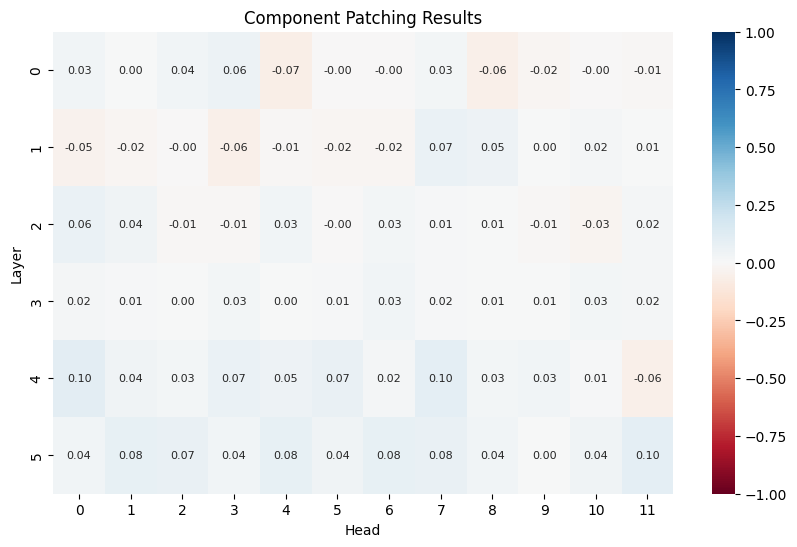

In [ ]:
plot_components(mean_head_outputs.to("cpu").numpy(), save_path=None)

## If you want to dive into the details of these experiments check out our other notebook!